In [1]:
import time
import gc
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sys
import os
sys.path.append(os.getcwd())
from visualizer.main import Visualizer 
# Importujemy bezpośrednio z pliku quadtree.py
from algorithms.quadtree.quadtree import QuadTree, Rectangle, Point, build_quadtree
from algorithms.quadtree.quadtree_visualization import quadtree_vis
from algorithms.quadtree.quadtree_query_visualization import visualize_quadtree_query

from algorithms.utils.build_tree import build_tree, get_points_in_area
from algorithms.utils.visualize_search_result import visualize_search_result

from points_generators import *

from algorithms.kd_tree.kd_class import *
from algorithms.kd_tree.kd_build_visualization import *
from algorithms.kd_tree.kd_query_visualization import * 

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import random

In [5]:
def points_visualization(points):
    vis = Visualizer()
    for pkt in points:
        vis.add_point(pkt, color = 'blue')
    return vis

## Wprowadzenie

Notatnik ten ma służyć jako narzędzie pozwalające na porównanie działania strktur KDTree oraz quadtree w zapytaniach, polegających na szukaniu punktów zawartych w obrębie prostokata

# Wizualizacja budowy oraz działania algorytmów #

Poniżej pokżemy wizualizacje przedstawiającą budowę oraz wizualizację zapytania dla 100 punktów wylosowanych jednostajnie z przedziału [0, 800] x [0, 800]

In [6]:
points = [(random.uniform(0, 800), random.uniform(0, 800)) for _ in range(100)]

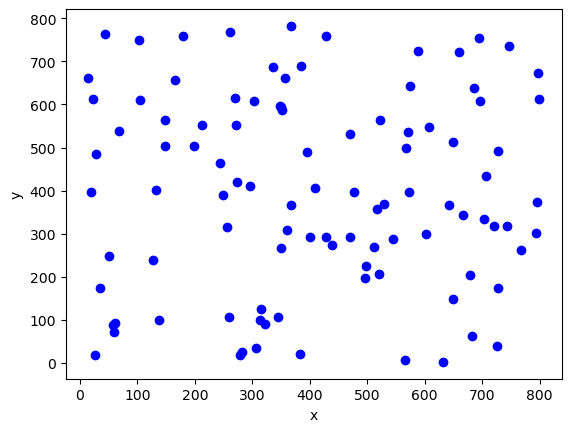

In [7]:
points_visualization(points).show()

## quadtree ##

budowa quadtree wizualizacja

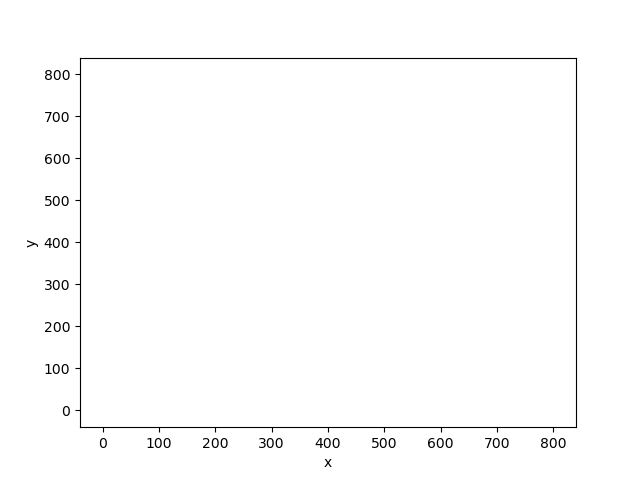

In [10]:
screen_boundary = Rectangle(400, 400, 400, 400)
k = 4
vis= quadtree_vis(points, screen_boundary, k)
vis.show_gif(interval=200)

działanie zapytania quadtree

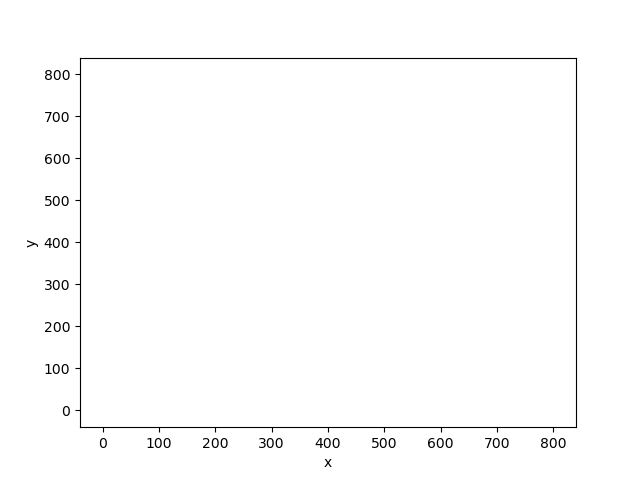

In [15]:

search_area = Rectangle(400, 350, 200, 150)
vis_query = visualize_quadtree_query(points, search_area, screen_boundary, 4)
vis_query.show_gif(interval=200) 

## kd-tree ##

wizualizacja budowy kd-tree

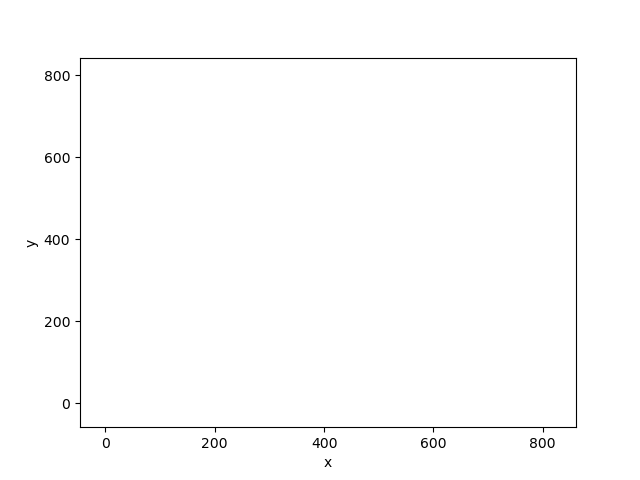

In [12]:
vis_kd = kd_build_visualization2(points)
vis_kd.show_gif()

działanie kd-tree wizualizacja

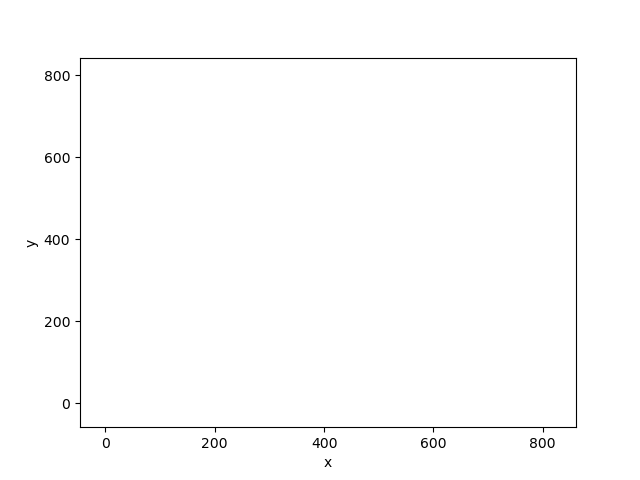

In [14]:
tree = KDTree(points)
query_box = (200, 600, 200, 500) # x_min, x_max, y_min, y_max
vis_kd2 = visualize_kdtree_query2(tree, points, query_box)
vis_kd2.show_gif(interval=150)

In [ ]:
search_area = Rectangle(300, 300, 100, 100)

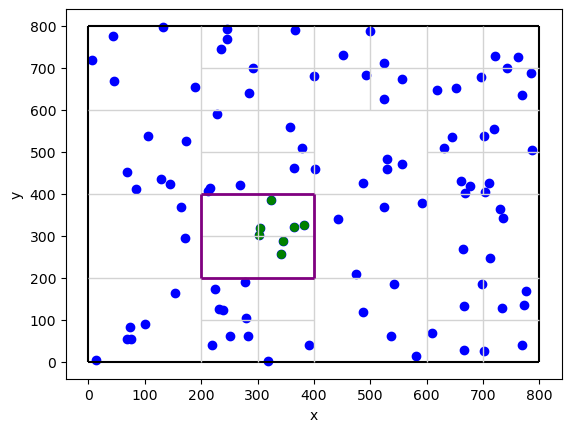

In [ ]:
found_points = get_points_in_area("quadtree", points, search_area, 4)
vis4 = visualize_search_result(points, search_area, found_points, "quadtree")
vis4.show()

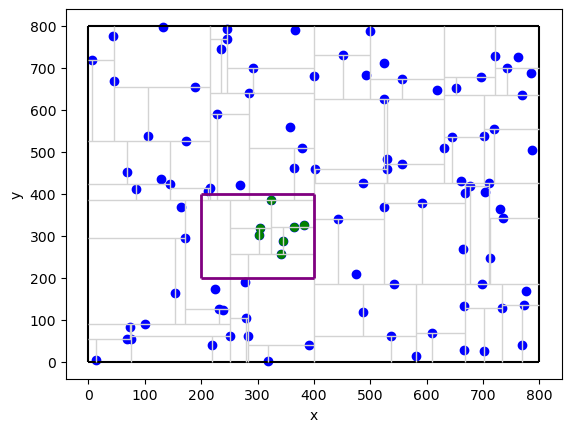

In [ ]:
found_points = get_points_in_area("kdtree", points, search_area, 4)
vis5 = visualize_search_result(points, search_area, found_points, "kdtree")
vis5.show()

## Porównanie działania algorytmów ##

Chcemy teraz porównać działanie obydwu algorytmów na wybranych zbiorach testowych

In [31]:
def get_uniform(n): return generate_uniform_points(0, 1000, n)
def get_normal(n): return generate_normal_points(500, 50, n)
def get_clusters(n): return generate_clustered_points([(200, 200), (200, 800), (800, 200), (800, 800)], 30, n // 4)
def get_collinear(n): return generate_collinear_points((0,0), (1000,1000), n, x_range=1000)
def get_square_diags(n): return generate_square_points((0,0), (1000,0), (1000,1000), (0,1000), n//4, n//4)
def get_grid(n):
    side = int(np.sqrt(n))
    pts = generate_grid_points(side)
    scale = 1000 / max(side, 1)
    return [(p[0]*scale, p[1]*scale) for p in pts]
def get_spiral(n): return generate_spiral_points(n, (500,500), 450, 5)

# ==========================================
# 3. KONFIGURACJA TESTÓW
# ==========================================

N_VALUES = [1000, 5000, 10000, 25000, 50000, 75000, 100000, 200000, 500000]

TEST_CONFIGS = [
    {"name": "Uniform", "gen": get_uniform, "query": (400, 600, 400, 600)},
    {"name": "Normal (Gauss)", "gen": get_normal, "query": (480, 520, 480, 520)},
    {"name": "Clusters", "gen": get_clusters, "query": (150, 250, 750, 850)},
    {"name": "Diagonal", "gen": get_collinear, "query": (450, 550, 450, 550)},
    {"name": "Spiral", "gen": get_spiral, "query": (550, 750, 450, 650)},
    {"name": "Square + Diags", "gen": get_square_diags, "query": (400, 600, 400, 600)},
    {"name": "Grid", "gen": get_grid, "query": (100, 300, 100, 300)}
]

# ==========================================
# 4. SILNIK TESTOWY (AVERAGED)
# ==========================================

print(f"🚀 ROZPOCZYNAM TESTY (Zapis do: data/*.csv oraz plots/*.png)...")

for config in TEST_CONFIGS:
    name = config["name"]
    safe_name = name.replace(" ", "_").replace("(", "").replace(")", "").replace("+", "plus")
    gen_func = config["gen"]
    q_rect = config["query"]
    
    print(f"\n📁 Przetwarzanie zbioru: {name}")
    print(f"{'N':<8} | {'KD Build':<10} | {'QT Build':<10} | {'KD Query':<10} | {'QT Query':<10} | {'Found':<6}")
    print("-" * 70)
    
    # Parametry dla QuadTree
    q_w = (q_rect[1] - q_rect[0]) / 2
    q_h = (q_rect[3] - q_rect[2]) / 2
    q_cx = q_rect[0] + q_w
    q_cy = q_rect[2] + q_h
    qt_query_obj = Rectangle(q_cx, q_cy, q_w, q_h)

    stats = []

    for n in N_VALUES:
        try: pts = gen_func(n)
        except: pts = []
        if not pts: continue
        
        random.shuffle(pts)
        
        if n <= 5000: repeats = 30
        elif n <= 20000: repeats = 10
        else: repeats = 3

        # KD Build
        gc.collect(); gc.disable()
        start_t = time.perf_counter()
        for _ in range(repeats): kd = KDTree(pts)
        t_build_kd = (time.perf_counter() - start_t) / repeats
        gc.enable()
        
        # QT Build
        xs, ys = [p[0] for p in pts], [p[1] for p in pts]
        min_x, max_x = min(xs), max(xs)
        min_y, max_y = min(ys), max(ys)
        dim = max(max_x - min_x, max_y - min_y) / 2 + 5
        qt_bound = Rectangle((min_x+max_x)/2, (min_y+max_y)/2, dim, dim)
        qt_pts = [Point(p[0], p[1]) for p in pts]

        gc.collect(); gc.disable()
        start_t = time.perf_counter()
        for _ in range(repeats): qt = build_quadtree(qt_pts, qt_bound, 10)
        t_build_qt = (time.perf_counter() - start_t) / repeats
        gc.enable()

        # Queries
        q_repeats = repeats * 10
        
        start_t = time.perf_counter()
        for _ in range(q_repeats): 
            res = kd.query(q_rect)
            found_kd = len(res)
        t_query_kd = (time.perf_counter() - start_t) / q_repeats
        
        start_t = time.perf_counter()
        for _ in range(q_repeats): 
            res_qt = []
            qt.query(qt_query_obj, res_qt)
            found_qt = len(res_qt)
        t_query_qt = (time.perf_counter() - start_t) / q_repeats
        
        print(f"{n:<8} | {t_build_kd:.6f}s  | {t_build_qt:.6f}s  | {t_query_kd:.6f}s  | {t_query_qt:.6f}s  | {found_kd}")
        
        stats.append({
            "N": n, "Build_KD": t_build_kd, "Build_QT": t_build_qt,
            "Query_KD": t_query_kd, "Query_QT": t_query_qt, "Found": found_kd
        })

    # Zapis CSV do folderu data/
    df = pd.DataFrame(stats)
    csv_path = os.path.join('data', f"{safe_name}.csv")
    df.to_csv(csv_path, index=False)
    
    # Generowanie WYKRESU dla tego zbioru
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"Analiza wydajności: {name}", fontsize=16)
    
    # Wykres 1: Budowa
    ax1.plot(df["N"], df["Build_KD"], 'o-', label="KD-Tree", color="blue")
    ax1.plot(df["N"], df["Build_QT"], 's--', label="QuadTree", color="orange")
    ax1.set_title("Czas Budowy (Build Time)")
    ax1.set_xlabel("Liczba punktów (N)")
    ax1.set_ylabel("Czas [s]")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Wykres 2: Zapytanie
    ax2.plot(df["N"], df["Query_KD"], 'o-', label="KD-Tree", color="green")
    ax2.plot(df["N"], df["Query_QT"], 's--', label="QuadTree", color="red")
    ax2.set_title("Czas Zapytania (Query Time)")
    ax2.set_xlabel("Liczba punktów (N)")
    ax2.set_ylabel("Czas [s]")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Zapis PNG do folderu plots/
    plot_path = os.path.join('plots', f"{safe_name}.png")
    plt.savefig(plot_path, dpi=100)
    plt.close(fig) # Zamknij figurę, żeby nie zapchać pamięci
    
    print(f"   💾 Zapisano: CSV -> {csv_path}, Wykres -> {plot_path}")

print("\n✅ WSZYSTKIE TESTY ZAKOŃCZONE.")

🚀 ROZPOCZYNAM TESTY (Zapis do: data/*.csv oraz plots/*.png)...

📁 Przetwarzanie zbioru: Uniform
N        | KD Build   | QT Build   | KD Query   | QT Query   | Found 
----------------------------------------------------------------------
1000     | 0.003164s  | 0.003661s  | 0.000060s  | 0.000029s  | 42
5000     | 0.017702s  | 0.011535s  | 0.000149s  | 0.000082s  | 188
10000    | 0.034496s  | 0.029636s  | 0.000251s  | 0.000121s  | 397
25000    | 0.103754s  | 0.097718s  | 0.000610s  | 0.000395s  | 1017
50000    | 0.259779s  | 0.173974s  | 0.000611s  | 0.000685s  | 2052
75000    | 0.330415s  | 0.280027s  | 0.000784s  | 0.001109s  | 3031
100000   | 0.514151s  | 0.386352s  | 0.000890s  | 0.001490s  | 3953
200000   | 1.346653s  | 0.881232s  | 0.001652s  | 0.003582s  | 8090
500000   | 4.565099s  | 2.935177s  | 0.003490s  | 0.022920s  | 19933
   💾 Zapisano: CSV -> data/Uniform.csv, Wykres -> plots/Uniform.png

📁 Przetwarzanie zbioru: Normal (Gauss)
N        | KD Build   | QT Build   | KD Query 